<a href="https://colab.research.google.com/github/shivanshu1641/OCR-using-COCO-TEXT/blob/main/Group_1_Text_Detection_(Colab_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vidhi Punjabi TE COMP B 55

# **Importing Modules**

In [ ]:
from shutil import copyfile
import shutil  
from keras import backend as K
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import os
from os import path
from os import walk
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,GlobalMaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import layers
import keras
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import json
import pandas as pd
%matplotlib inline
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import cv2
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *
from keras.applications.mobilenet_v2 import MobileNetV2
import random
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.models import model_from_json
import matplotlib.pyplot as plt
import os

import numpy as np
import os
import tensorflow as tf
from scipy.io import loadmat
import cv2
import matplotlib.pyplot as plt

# **Google Authorization**

In [ ]:
#Mounting Semaphore
#S = 0

In [ ]:
#Provide ocrocr12345@gmail.com 
drive.mount('/content/train')

Mounted at /content/train


# **Loading Dataset From Drive**

In [ ]:
!unzip "/content/train/My Drive/Data (1).zip"
!unzip "/content/train/My Drive/coco-text-master.zip"
!unzip "/content/train/My Drive/COCO_Text.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Train/COCO_train2014_000000443575.jpg  
  inflating: Train/COCO_train2014_000000184397.jpg  
  inflating: Train/COCO_train2014_000000316012.jpg  
  inflating: Train/COCO_train2014_000000186298.jpg  
  inflating: Train/COCO_train2014_000000036748.jpg  
  inflating: Train/COCO_train2014_000000536149.jpg  
  inflating: Train/COCO_train2014_000000449610.jpg  
  inflating: Train/COCO_train2014_000000164142.jpg  
  inflating: Train/COCO_train2014_000000035985.jpg  
  inflating: Train/COCO_train2014_000000291868.jpg  
  inflating: Train/COCO_train2014_000000423202.jpg  
  inflating: Train/COCO_train2014_000000545364.jpg  
  inflating: Train/COCO_train2014_000000464240.jpg  
  inflating: Train/COCO_train2014_000000254774.jpg  
  inflating: Train/COCO_train2014_000000034528.jpg  
  inflating: Train/COCO_train2014_000000021811.jpg  
  inflating: Train/COCO_train2014_000000376502.jpg  
  inflating: Train/COCO_train2014_000000166356.j

In [ ]:
!unzip "/content/train/My Drive/charDetect-I.zip"

Archive:  /content/train/My Drive/charDetect-I.zip
  inflating: charDetect-I.h5         


In [ ]:
drive.flush_and_unmount()

In [ ]:
shutil.move('/content/coco-text-master/coco_evaluation.py','/content')
shutil.move('/content/coco-text-master/coco_text.py','/content')

'/content/coco_text.py'

#OCR Task Description

## Various Types of OCR

##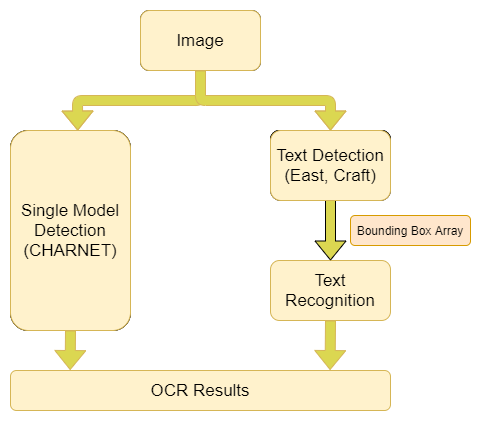

## Text Detection

##Input

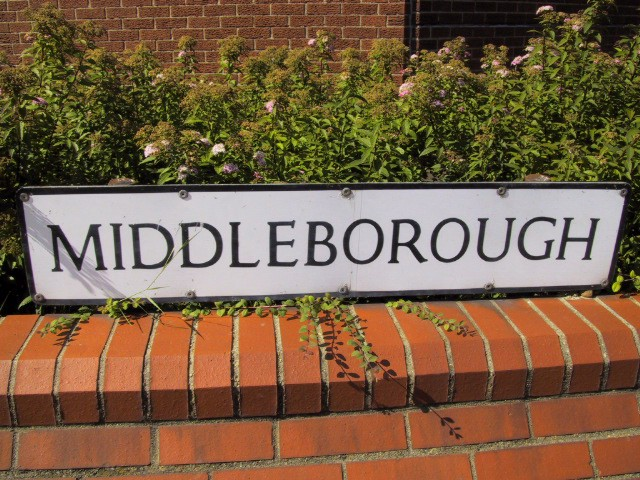

##Output


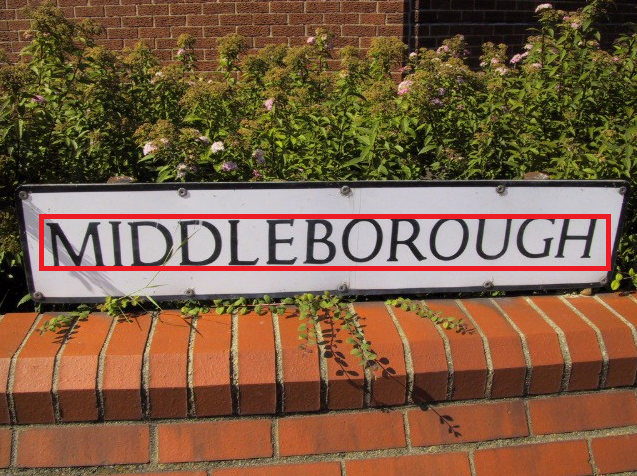

#Processing Data

In [ ]:
def getFiles(path):
  return [name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]

##Checking Files 

In [ ]:
trainPath = "/content/Train/"
valPath = "/content/Val/"
trainFiles = getFiles(trainPath)
valFiles = getFiles(valPath)

In [ ]:
print(len(trainFiles))
print(len(valFiles))

15124
3522


In [ ]:
print(trainFiles[0])

COCO_train2014_000000065518.jpg


##Import COCOTEXT api

In [ ]:
import coco_text
import coco_evaluation

In [ ]:
ct = coco_text.COCO_Text('COCO_Text.json')

loading annotations into memory...
0:00:01.932710
creating index...
index created!


In [ ]:
ct.info()

url: http://vision.cornell.edu/se3/coco-text/
date_created: 2017-03-28
version: 1.4
description: This is 1.4 version of the 2017 COCO-Text dataset.
author: COCO-Text group


In [ ]:
#Preparing Train DataFrame
imgs_train = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])
anns3 = ct.getAnnIds(imgIds=ct.train, catIds = [('legibility','legible')])
ct.getImgIds(catIds = [])
files_anns_df_train = []
for idx in range(len(imgs_train)):
  temp_dict = ct.loadImgs(imgs_train[idx])[0]
  files_anns_df_train.append([temp_dict['file_name'],temp_dict['id']])
files_anns_df_train = pd.DataFrame(files_anns_df_train,columns = ['file_name','id'])


In [ ]:
print(len(files_anns_df_train))
print(len(anns3))

15124
70887


In [ ]:
#Preparing val DF
imgs_val = ct.getImgIds(imgIds=ct.val,
                    catIds=[('legibility','legible')])
files_anns_df_val = []
for idx in range(len(imgs_val)):
  temp_dict = ct.loadImgs(imgs_val[idx])[0]
  files_anns_df_val.append([temp_dict['file_name'],temp_dict['id']])
files_anns_df_val = pd.DataFrame(files_anns_df_val,columns = ['file_name','id'])

In [ ]:
def getIDbyFilename(filename,df):
  listOfPos = [] 
  result = df.isin([filename]) 
  seriesObj = result.any() 
  columnNames = list(seriesObj[seriesObj == True].index) 
  for col in columnNames: 
    rows = list(result[col][result[col] == True].index) 
  for row in rows: 
    listOfPos.append([row, col]) 
  return df.id[listOfPos[0][0]]

In [ ]:
id = getIDbyFilename(trainFiles[0],files_anns_df_train)
print(id)

65518


#Basic Data visualization

In [ ]:
def showTrainImage(idx):
  print(trainFiles[idx])
  id = getIDbyFilename(trainFiles[idx],files_anns_df_train)
  img = cv2.imread(os.path.join(trainPath, trainFiles[idx]))
  ct = coco_text.COCO_Text('COCO_Text.json')
  print(img.shape)
  w = img.shape[0]
  h = img.shape[1]
  img = cv2.resize(img, (512,512))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
  img = img/255
  plt.figure()
  plt.imshow(img)
  annIds = ct.getAnnIds(id, catIds = [('legibility','legible')], areaRng = [1000, 10000])
  anns = ct.loadAnns(annIds)
  anns2  = anns.copy()
  print(len(anns2))
  for i in range(0,len(anns2)):
    anns2[i]['bbox'][0] = anns[i]['bbox'][0]*512/h
    anns2[i]['bbox'][1] = anns[i]['bbox'][1]*512/w
    anns2[i]['bbox'][2] = anns[i]['bbox'][2]*512/h
    anns2[i]['bbox'][3] = anns[i]['bbox'][3]*512/w  
    print(anns[i]['bbox'][0])
    print(anns[i]['bbox'][2])
  ct.showAnns(anns2)    

COCO_train2014_000000266455.jpg
loading annotations into memory...
0:00:01.836298
creating index...
index created!
(478, 640, 3)
1
83.2
92.8


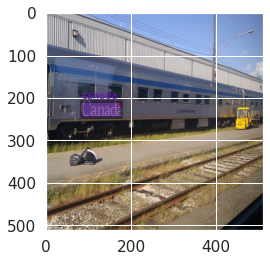

In [ ]:
showTrainImage(15)

# Model Preparation

In [ ]:
#Declaring constants for model
from tensorflow.keras.utils import Sequence
GRID_X = 16
GRID_Y = 16
BATCH_SIZE = 16
IMG_W = 512
IMG_H = 512

In [ ]:
ct = coco_text.COCO_Text('COCO_Text.json')

In [ ]:
testFiles = valFiles[len(valFiles)//2:]
valFiles = valFiles[:len(valFiles)//2]

In [ ]:
print(len(testFiles))
print(len(valFiles))

1761
1761


In [ ]:
random.shuffle(trainFiles)
random.shuffle(valFiles)
random.shuffle(testFiles)

##Predict Functions

In [ ]:
def decodeBoxes(output , ht , wd):
    img_ht = ht
    img_wd = wd
    threshold = 0.5
    grid_h,grid_w = output.shape[:2]
    final_boxes = []
    scores = []
    for i in range(grid_h):
        for j in range(grid_w):
            if output[i,j,0,0] > threshold:
                temp = output[i,j,0,1:5]   
                x_unit = ((j + (temp[0]))/grid_w)*img_wd
                y_unit = ((i + (temp[1]))/grid_h)*img_ht
                width = temp[2]*img_wd*1.3
                height = temp[3]*img_ht*1.3  
                final_boxes.append([x_unit - width/2,y_unit - height/2 ,x_unit + width/2,y_unit + height/2])
                scores.append(output[i,j,0,0])
    
    return final_boxes,scores



def iou(box1,box2):
    x1 = max(box1[0],box2[0])
    x2 = min(box1[2],box2[2])
    y1 = max(box1[1] ,box2[1])
    y2 = min(box1[3],box2[3])
    inter = (x2 - x1)*(y2 - y1)
    area1 = (box1[2] - box1[0])*(box1[3] - box1[1])
    area2 = (box2[2] - box2[0])*(box2[3] - box2[1])
    fin_area = area1 + area2 - inter
    iou = inter/fin_area
    return iou



def nms(boxes , scores , iou_num):

    scores_sort = scores.argsort().tolist()
    keep = []
    while(len(scores_sort)):

        index = scores_sort.pop()
        keep.append(index)
        if(len(scores_sort) == 0):
            break
        iou_res = []
        for i in scores_sort:
            iou_res.append(iou(boxes[index] , boxes[i]))
        iou_res = np.array(iou_res)
        filtered_indexes = set((iou_res > iou_num).nonzero()[0])
        scores_sort = [v for (i,v) in enumerate(scores_sort) if i not in filtered_indexes]
    final = []
    for i in keep:
        final.append(boxes[i])
    return final


def decodeOutput(output , ht , wd , iou):
    
    boxes , scores = decodeBoxes(output ,ht ,wd)
    boxes = nms(boxes,np.array(scores) , iou)
    return boxes
    


In [ ]:
lossList = []

# Vedant Pandya TE COMP B 49


##Defining loss function

In [ ]:
def yolo_loss_func(y_true,y_pred):
    l_coords = 5.0
    l_noob = 0.5
    coords = y_true[:,:,:,:,0] * l_coords
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob)
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true))
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    w_loss = K.sum(K.square(K.sqrt(abs(w_pred)) - K.sqrt(abs(w_true)))*coords)
    h_loss = K.sum(K.square(K.sqrt(abs(h_pred)) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    lossList.append([p_pred,x_pred,yy_pred,w_pred,h_pred])
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss
    return loss

## Defining Generator

In [ ]:
#Generator Function for train
def generateImagesNewTrain(batchsize):
    x_batch = np.zeros((batchsize, IMG_W, IMG_H, 3))       
    y_batch = np.zeros((batchsize, GRID_X, GRID_Y, 1, 5))
    count = 0
    while True:  
      for fname in trainFiles:
              if(count>=batchsize):
                p=1/127.5
                x_batch = np.dot(np.subtract(x_batch,127.5),p)
                yield  x_batch, y_batch
                count = 0
                x_batch = np.zeros((batchsize, IMG_W, IMG_H, 3))       
                y_batch = np.zeros((batchsize, GRID_X, GRID_Y, 1, 5))
              id = getIDbyFilename(fname, files_anns_df_train)
              img = cv2.imread(os.path.join(trainPath, fname))
              w = img.shape[0]                  
              h = img.shape[1]
              #print(w,h)
              img = cv2.resize(img, (IMG_W,IMG_H))
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
              x_batch[count] = img
              annIds = ct.getAnnIds(id, catIds = [('legibility','legible')], areaRng = [1000, 10000])
              anns = ct.loadAnns(annIds)
              anns2  = anns.copy()
              #print(len(anns2))
              #print(fname)
              f = 0 
              for i in range(0,len(anns2)):
                left =  anns2[i]['bbox'][0]*512/h
                top =  anns2[i]['bbox'][1]*512/w
                width =  anns2[i]['bbox'][2]*512/h
                height =  anns2[i]['bbox'][3]*512/w
                center_x = (left + (width/2))*GRID_X/512
                center_y = (top + (height/2))*GRID_Y/512
                grid_x = int(np.floor(center_x))
                grid_y = int(np.floor(center_y))
                #print(width)
                #print(center_x)
                width = width/512
                height = height/512
                #print(grid_x," ",grid_y)
                if(grid_x > 15):
                      grid_x = 15
                if(grid_y>15):
                      grid_y = 15
                #print("Center_X: ",center_x - grid_x," Center_Y: ",center_y - grid_y, "Width: ",width,"Height: ",height)
                y_batch[count, int(grid_x), int(grid_y), 0,0] = 0 
                y_batch[count, int(grid_x), int(grid_y), 0,1] = center_x - grid_x
                y_batch[count, int(grid_x), int(grid_y), 0,2] = center_y - grid_y
                y_batch[count, int(grid_x), int(grid_y), 0,3] = width
                y_batch[count, int(grid_x), int(grid_y), 0,4] = height
              count = count + 1      
              #print(count)
trainGeneratorNew = generateImagesNewTrain(8)


In [ ]:
#Generator Function for validation
def generateImagesNewVal(batchsize):
    x_batch = np.zeros((batchsize, IMG_W, IMG_H, 3))       
    y_batch = np.zeros((batchsize, GRID_X, GRID_Y, 1, 5))
    count = 0
    while True:  
      for fname in valFiles:
              if(count>=batchsize):
                p=1/127.5
                x_batch = np.dot(np.subtract(x_batch,127.5),p)
                yield  x_batch, y_batch
                count = 0
                x_batch = np.zeros((batchsize, IMG_W, IMG_H, 3))       
                y_batch = np.zeros((batchsize, GRID_X, GRID_Y, 1, 5))
              id = getIDbyFilename(fname, files_anns_df_val)
              img = cv2.imread(os.path.join(valPath, fname))
              w = img.shape[0]
              h = img.shape[1]
              #print(w,h)
              img = cv2.resize(img, (IMG_W,IMG_H))
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
              x_batch[count] = img
              annIds = ct.getAnnIds(id, catIds = [('legibility','legible')], areaRng = [1000, 10000])
              anns = ct.loadAnns(annIds)
              anns2  = anns.copy()
              #print(len(anns2))
              #print(fname)
              f = 0 
              for i in range(0,len(anns2)):
                left =  anns2[i]['bbox'][0]*512/h
                top =  anns2[i]['bbox'][1]*512/w
                width =  anns2[i]['bbox'][2]*512/h
                height =  anns2[i]['bbox'][3]*512/w
                center_x = (left + (width/2))*GRID_X/512
                center_y = (top + (height/2))*GRID_Y/512
                grid_x = int(np.floor(center_x))
                grid_y = int(np.floor(center_y))
                #print(width)
                #print(center_x)
                width = width/512
                height = height/512
                #print(grid_x," ",grid_y)
                if(grid_x > 15):
                      grid_x = 15
                if(grid_y>15):
                      grid_y = 15
                #print("Center_X: ",center_x - grid_x," Center_Y: ",center_y - grid_y, "Width: ",width,"Height: ",height)
                y_batch[count, int(grid_x), int(grid_y), 0,0] = 0
                y_batch[count, int(grid_x), int(grid_y), 0,1] = center_x - grid_x
                y_batch[count, int(grid_x), int(grid_y), 0,2] = center_y - grid_y
                y_batch[count, int(grid_x), int(grid_y), 0,3] = width
                y_batch[count, int(grid_x), int(grid_y), 0,4] = height
              count = count + 1      
              #print(count)
valGeneratorNew = generateImagesNewVal(8)


In [ ]:
#Generator Function for train
def generateImagesNewTest(batchsize):
    x_batch = np.zeros((batchsize, IMG_W, IMG_H, 3))       
    y_batch = np.zeros((batchsize, GRID_X, GRID_Y, 1, 5))
    count = 0
    while True:  
      for fname in testFiles:
              if(count>=batchsize):
                p=1/127.5
                x_batch = np.dot(np.subtract(x_batch,127.5),p)
                yield  x_batch, y_batch
                count = 0
                x_batch = np.zeros((batchsize, IMG_W, IMG_H, 3))       
                y_batch = np.zeros((batchsize, GRID_X, GRID_Y, 1, 5))
              id = getIDbyFilename(fname, files_anns_df_val)
              img = cv2.imread(os.path.join(valPath, fname))
              w = img.shape[0]
              h = img.shape[1]
              #print(w,h)
              img = cv2.resize(img, (IMG_W,IMG_H))
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
              x_batch[count] = img
              annIds = ct.getAnnIds(id, catIds = [('legibility','legible')], areaRng = [1000, 10000])
              anns = ct.loadAnns(annIds)
              anns2  = anns.copy()
              #print(len(anns2))
              #print(fname)
              f = 0 
              for i in range(0,len(anns2)):
                left =  anns2[i]['bbox'][0]*512/h
                top =  anns2[i]['bbox'][1]*512/w
                width =  anns2[i]['bbox'][2]*512/h
                height =  anns2[i]['bbox'][3]*512/w
                center_x = (left + (width/2))*GRID_X/512
                center_y = (top + (height/2))*GRID_Y/512
                grid_x = int(np.floor(center_x))
                grid_y = int(np.floor(center_y))
                #print(width)
                #print(center_x)
                width = width/512
                height = height/512
                #print(grid_x," ",grid_y)
                if(grid_x > 15):
                      grid_x = 15
                if(grid_y>15):
                      grid_y = 15
                #print("Center_X: ",center_x - grid_x," Center_Y: ",center_y - grid_y, "Width: ",width,"Height: ",height)
                y_batch[count, int(grid_x), int(grid_y), 0,0] = 0
                y_batch[count, int(grid_x), int(grid_y), 0,1] = center_x - grid_x
                y_batch[count, int(grid_x), int(grid_y), 0,2] = center_y - grid_y
                y_batch[count, int(grid_x), int(grid_y), 0,3] = width
                y_batch[count, int(grid_x), int(grid_y), 0,4] = height
              count = count + 1      
              #print(count)
testGeneratorNew = generateImagesNewTest(8)


##Defining Model

## BASE MODEL : MobileNetV2

## Model Building

In [ ]:
inp = (IMG_W, IMG_H, 3)
inp_tensor = Input(inp)
model = MobileNetV2( input_tensor= inp_tensor , include_top=False, weights='imagenet')
last_layer = model.output
conv = Conv2D(512,(3,3) , activation='relu' , padding='same')(last_layer)
conv = Dropout(0.4)(conv)
bn = BatchNormalization()(conv)
lr = LeakyReLU(alpha=0.1)(bn)
conv = Conv2D(128,(3,3) , activation='relu' , padding='same')(lr)
conv = Dropout(0.4)(conv)
bn = BatchNormalization()(conv)
lr = LeakyReLU(alpha=0.1)(bn)
conv = Conv2D(5,(3,3) , activation='relu' , padding='same')(lr)
final = Reshape((GRID_X,GRID_Y,1,5))(conv)
model = Model(inp_tensor,final)
    

9412608/9406464 [==============================] - 0s 0us/step


##Loaing Pre - Trained model

In [ ]:
model.load_weights("charDetect-I.h5")

In [ ]:
#Model Compile
opt = Adam(lr=0.0000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=yolo_loss_func , optimizer=opt )

##Model Training

In [ ]:
trainLoss = [15.4, 11.3]
valLoss = [14.04, 10.8]
history = model.fit(trainGeneratorNew ,
                  epochs=1 ,
                  batch_size = 8, 
                  steps_per_epoch= 1890 ,
                  validation_data=valGeneratorNew,
	                validation_steps=215
                  )


1890/1890 [==============================] - 2209s 1s/step - loss: 11.3706 - val_loss: 10.8547


In [ ]:
model.save_weights("charDetect-II.h5")

In [ ]:
trainLoss = [15.4, 11.3]
valLoss = [14.04, 10.8]
testLoss = [13.1887, 9.504]
testHistory = model.evaluate(testGeneratorNew, batch_size = 8, steps = 215)

215/215 [==============================] - 203s 942ms/step - loss: 13.1887


In [ ]:
trainLoss = [44.8,38.6,22,15.4, 11.3]
valLoss = [27.75, 25.34, 17.56 ,14.04, 10.8]
testLoss = [28.84, 15.6, 13.1887, 9.504,9.783]

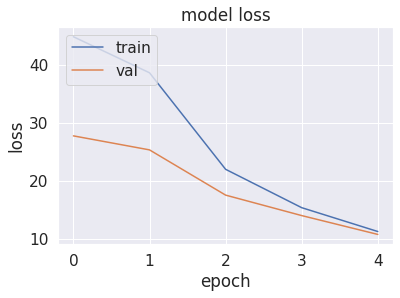

In [ ]:
#Plot Loss
plt.plot(trainLoss)
plt.plot(valLoss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

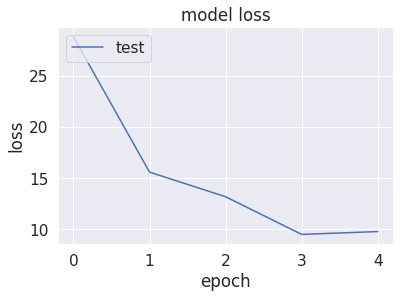

In [ ]:
#Plot Loss
plt.plot(testLoss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

## Model Prediction

In [ ]:
def predict(model , inp , iou , name):
    ans = model.predict(inp)
    boxes = decodeOutput(ans[0] , 512 , 512 , iou)
    img = ((inp + 1)/2)
    img = img[0]
    for i in boxes:
        i = [int(x) for x in i]
        img = cv2.rectangle(img , (i[0] ,i[1]) , (i[2] , i[3]) , color = (255,0,0) , thickness = 3)
    plt.grid(b=None)
    plt.imshow(img)
    plt.show()
    

(3001, 3999, 3)
(512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


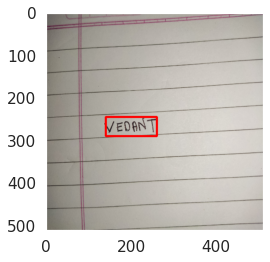

In [ ]:
img = "/content/test8.jpg"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1707, 2560, 3)
(512, 512, 3)


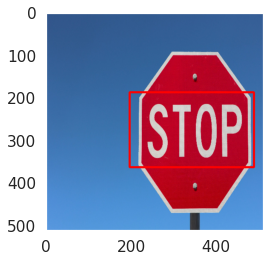

In [ ]:
img = "/content/detect1.jpg"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1218, 1280, 3)
(512, 512, 3)


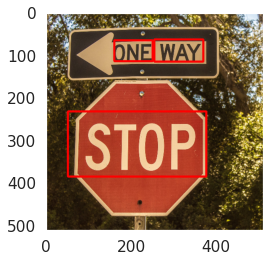

In [ ]:
img = "/content/detect2.jpg"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 400, 3)
(512, 512, 3)


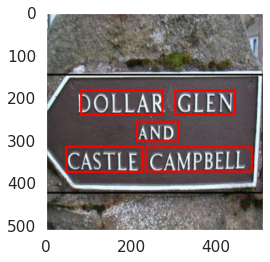

In [ ]:
img = "/content/detect3.jpg"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(640, 480, 3)
(512, 512, 3)


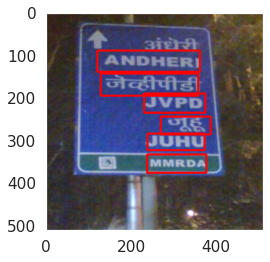

In [ ]:
img = "/content/detect4.jpg"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 600, 3)
(512, 512, 3)


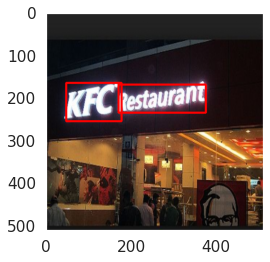

In [ ]:
img = "/content/detect5.jpg"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 451, 3)
(512, 512, 3)


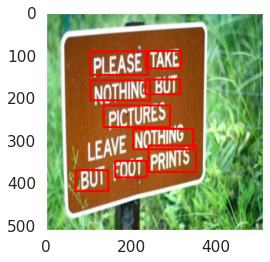

In [ ]:
img = "/content/detect6.png"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(388, 400, 3)
(512, 512, 3)


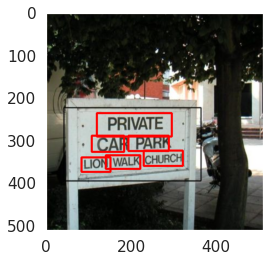

In [ ]:
img = "/content/detect7.jpg"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(520, 669, 3)
(512, 512, 3)


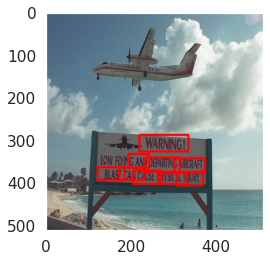

In [ ]:
img = "/content/detect8.jpg"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

(159, 318, 3)
(512, 512, 3)


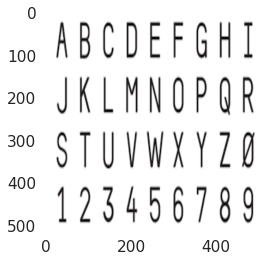

In [ ]:
img = "/content/detect9.png"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(545, 918, 3)
(512, 512, 3)


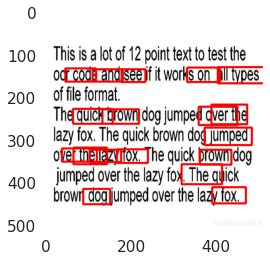

In [ ]:
img = "/content/detect10.png"
img = cv2.imread(img)
print(img.shape)
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
print(img.shape)
img = (img - 127.5)/127.5
predict(model, np.expand_dims(img,axis= 0), 0.5, "test")